In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8, 5)


import seaborn as sns

import statsmodels.api as sm
from patsy import dmatrices

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


import pickle

In [20]:
df = pd.read_csv("Churn_Modelling.csv")

In [21]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Quality

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [23]:
df.duplicated(subset="CustomerId").sum()

np.int64(0)

tidak terdapat data yang duplicate

In [24]:
# Drop data yang tidak diperlukan
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

In [25]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Report :
1. terdapat nasabah dengan score yang rendah yaitu 350.
2. tedapat nasabah yang memiliki umur hingga 92 tahun.
3. tedapat estimasi salary yang tergolong besar yaitu 199992.480000 dan sangat kecil 11.58, terdapat indikasi outliers
4. nasabah yang tergolong activate member sebesar 51.5%

# Exploratory Data Analytics

In [26]:
df["CreditScore"].quantile(0.50)

np.float64(652.0)

In [27]:
def credits_bin(credict_score):
    if credict_score >=650:
        return "650-850"
    if credict_score >= 500:
        return "500-649"
    elif credict_score >=300:
        return "350-499"
    else:
        return "<300"

def age_bin(age):
    if age >= 60:
        return "60+"
    elif age >= 50:
        return "50-59"
    elif age >= 40:
        return "40-49"
    elif age >= 30:
        return "30-39"
    elif age >= 25:
        return "25-30"
    else:
        return "<25"
    

In [28]:
df["CreditScoreBin"] = df["CreditScore"].apply(credits_bin)
df["AgeBin"] = df["Age"].apply(age_bin)

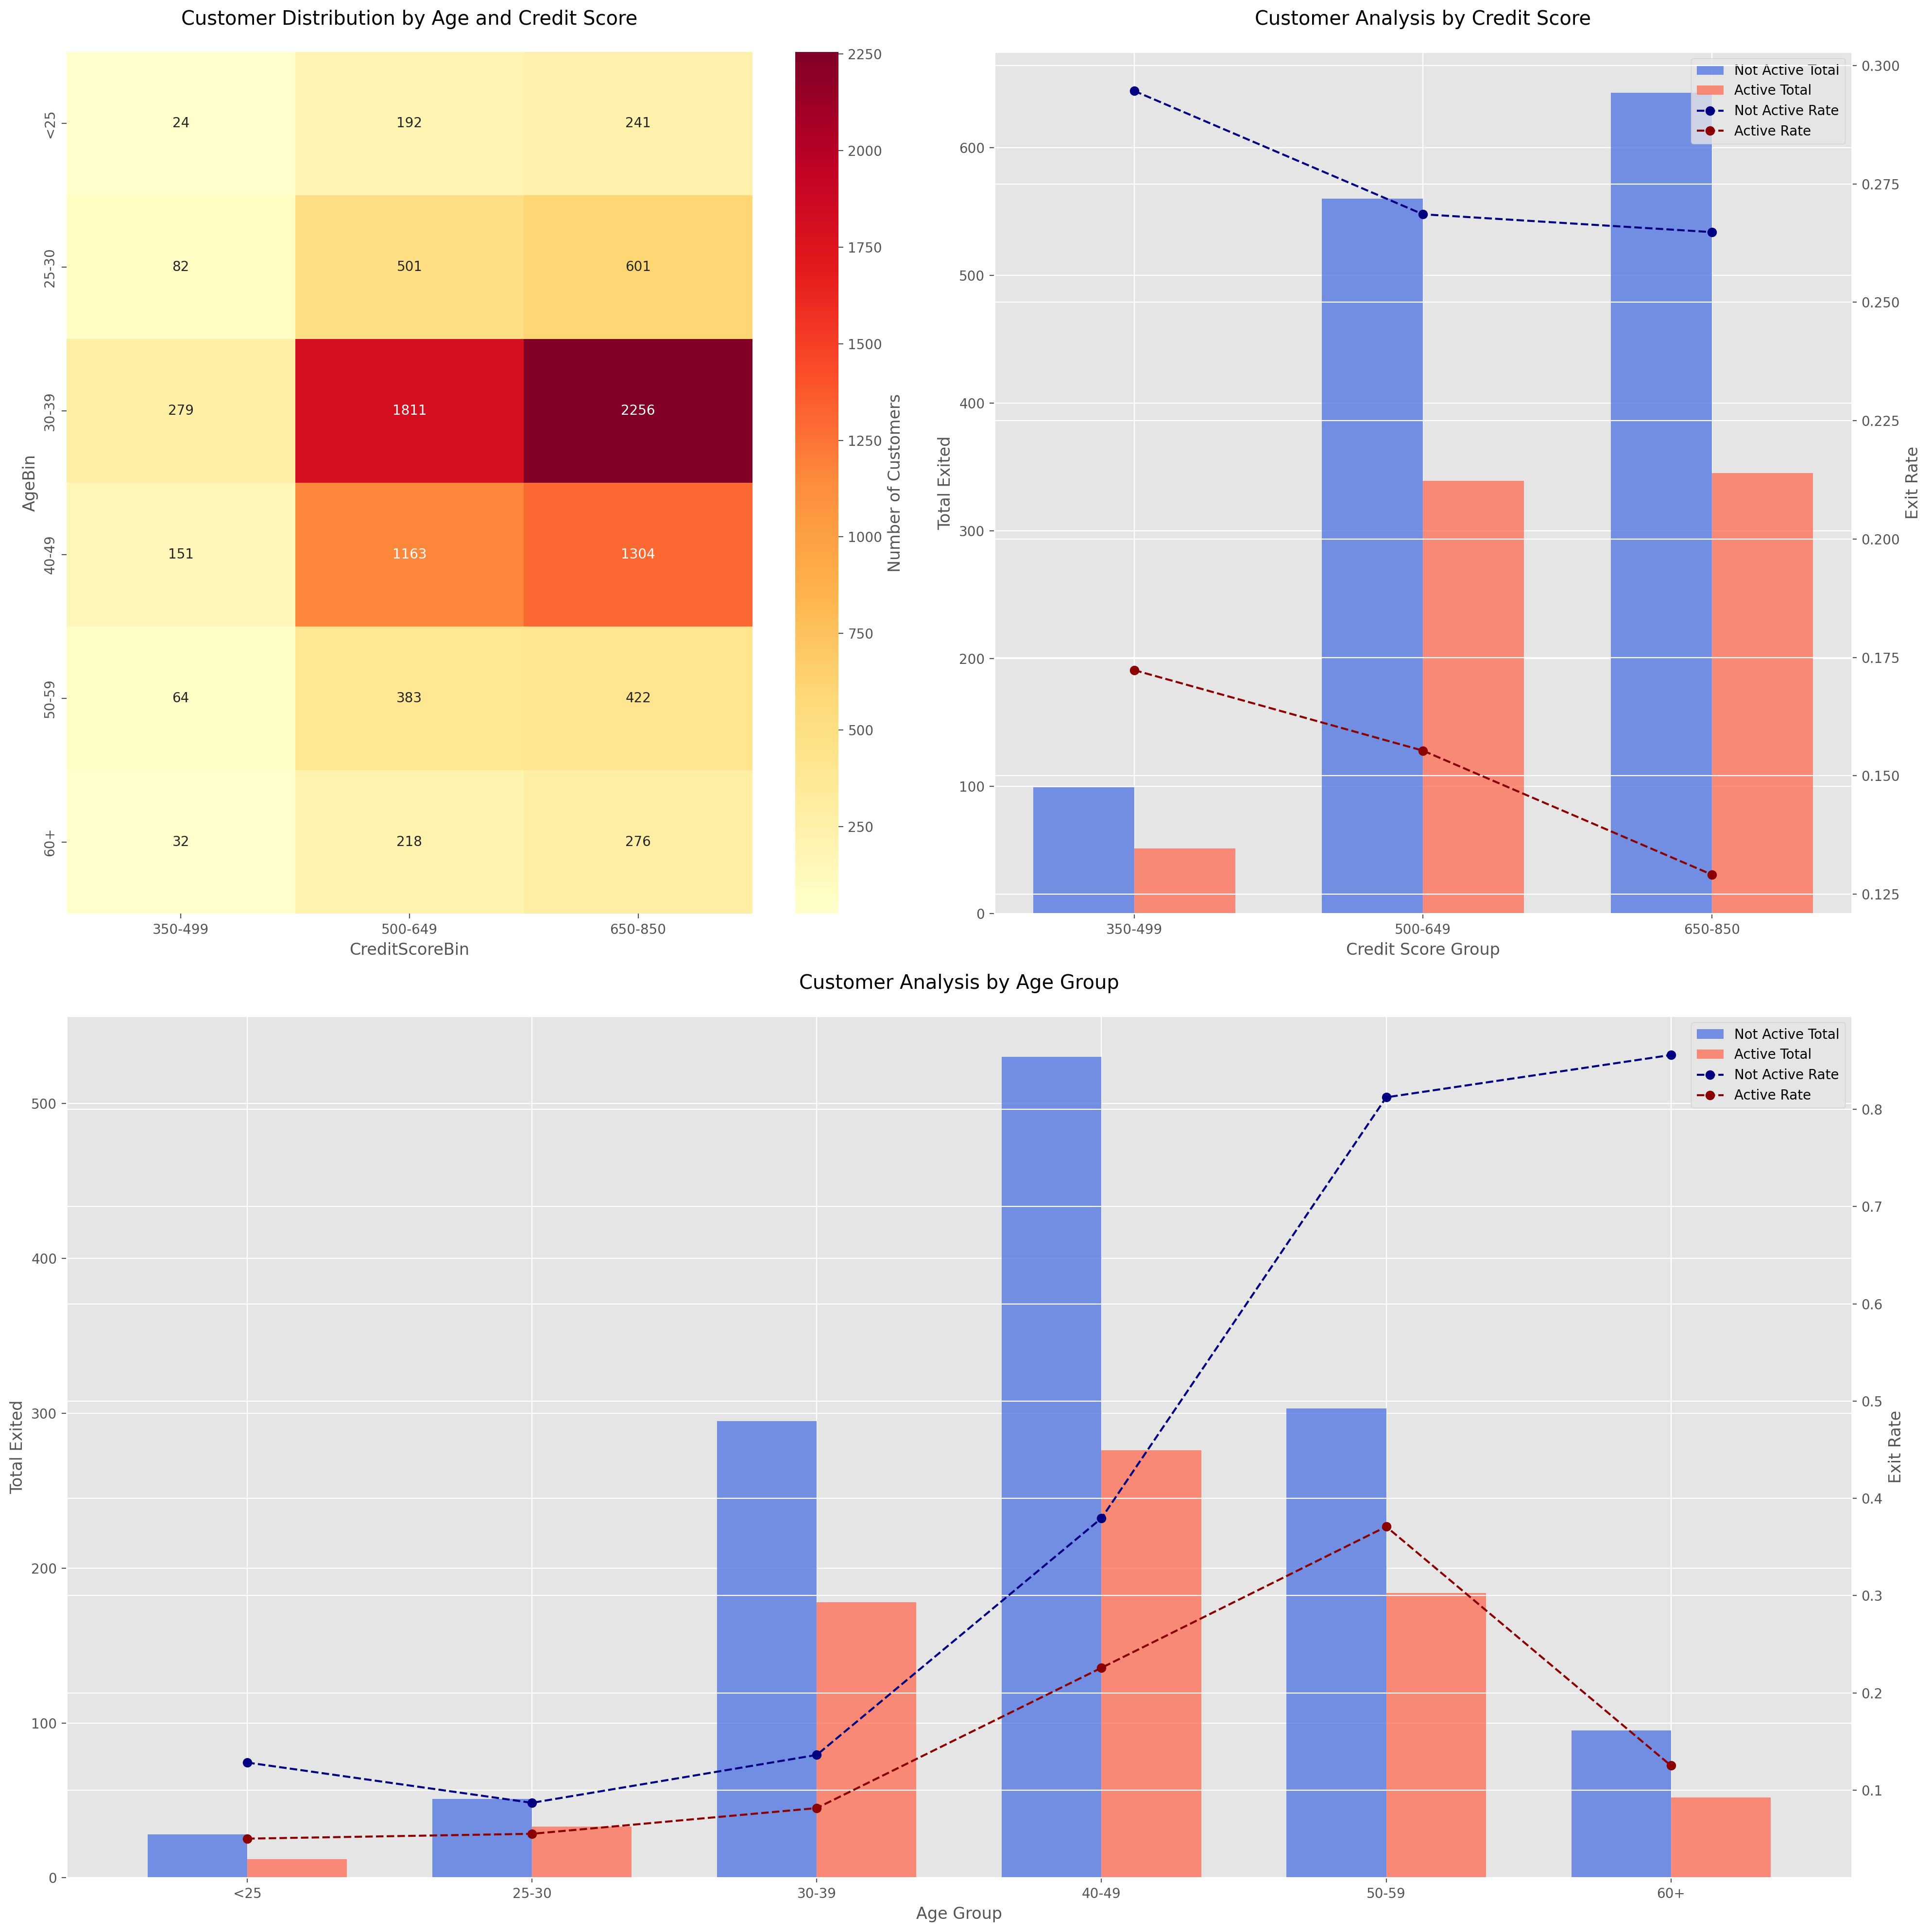

In [29]:
from matplotlib import gridspec
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,20))


gs = gridspec.GridSpec(2, 2, figure=fig)

# 1. Heatmap distribusi Age vs Credit Score
ax1 = fig.add_subplot(gs[0, 0])
pivot_data = pd.pivot_table(
    data=df,
    index=["AgeBin"],
    columns="CreditScoreBin",
    values="Exited",
    aggfunc="count"
).loc[["<25","25-30","30-39","40-49","50-59","60+"]]

sns.heatmap(pivot_data, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='g',
            ax=ax1,
            cbar_kws={'label': 'Number of Customers'})
ax1.set_title('Customer Distribution by Age and Credit Score', pad=20)

# 2. Credit Score Analysis
ax2 = fig.add_subplot(gs[0, 1])
temp = df.groupby(["CreditScoreBin","IsActiveMember"],as_index=False).agg({
    "Exited": ["sum","mean"]
})
temp.columns = [" ".join(x).strip() for x in temp.columns]

bar_width = 0.35
x = np.arange(len(temp["CreditScoreBin"].unique()))

bars1 = ax2.bar(x - bar_width/2,
               temp[temp["IsActiveMember"] == 0]["Exited sum"],
               bar_width,
               label="Not Active Member",
               color="royalblue",
               alpha=0.7)

bars2 = ax2.bar(x + bar_width/2,
               temp[temp["IsActiveMember"] == 1]["Exited sum"],
               bar_width,
               label="Active Member",
               color="tomato",
               alpha=0.7)

ax2_twin = ax2.twinx()
line1 = ax2_twin.plot(x, temp[temp["IsActiveMember"] == 0]["Exited mean"],
                     color='navy', linestyle="--", marker='o',
                     label="Not Active Member Rate")[0]
line2 = ax2_twin.plot(x, temp[temp["IsActiveMember"] == 1]["Exited mean"],
                     color='darkred', linestyle="--", marker='o',
                     label="Active Member Rate")[0]

ax2.set_xticks(x)
ax2.set_xticklabels(temp["CreditScoreBin"].unique())
ax2.set_title('Customer Analysis by Credit Score', pad=20)
ax2.set_xlabel('Credit Score Group')
ax2.set_ylabel('Total Exited')
ax2_twin.set_ylabel('Exit Rate')

lines = [bars1, bars2, line1, line2]
labels = ['Not Active Total', 'Active Total', 'Not Active Rate', 'Active Rate']
ax2.legend(lines, labels, loc='upper right')

# 3. Age Group Analysis
ax3 = fig.add_subplot(gs[1, :])
temp = df.groupby(["AgeBin","IsActiveMember"],as_index=False).agg({
    "Exited": ["sum","mean"]
})
temp.columns = [" ".join(x).strip() for x in temp.columns]


age_order = ["<25","25-30","30-39","40-49","50-59","60+"]
temp['AgeBin'] = pd.Categorical(temp['AgeBin'], categories=age_order, ordered=True)
temp = temp.sort_values('AgeBin')

x = np.arange(len(age_order))

bars1 = ax3.bar(x - bar_width/2,
               temp[temp["IsActiveMember"] == 0]["Exited sum"],
               bar_width,
               label="Not Active Member",
               color="royalblue",
               alpha=0.7)

bars2 = ax3.bar(x + bar_width/2,
               temp[temp["IsActiveMember"] == 1]["Exited sum"],
               bar_width,
               label="Active Member",
               color="tomato",
               alpha=0.7)

ax3_twin = ax3.twinx()
line1 = ax3_twin.plot(x, temp[temp["IsActiveMember"] == 0]["Exited mean"],
                     color='navy', linestyle="--", marker='o',
                     label="Not Active Member Rate")[0]
line2 = ax3_twin.plot(x, temp[temp["IsActiveMember"] == 1]["Exited mean"],
                     color='darkred', linestyle="--", marker='o',
                     label="Active Member Rate")[0]

ax3.set_xticks(x)
ax3.set_xticklabels(age_order)
ax3.set_title('Customer Analysis by Age Group', pad=20)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Total Exited')
ax3_twin.set_ylabel('Exit Rate')

lines = [bars1, bars2, line1, line2]
labels = ['Not Active Total', 'Active Total', 'Not Active Rate', 'Active Rate']
ax3.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# Analysis

**Customer Distribution**: <br>
- The majority of customers are aged 30-39 with credit scores between 650 and 850.
- The age group also dominates in the 500 - 649 credit score range, with 1811 customers.
- Customers in both younger age group (< 25 years) and retirement age (60+ years) are underrepresented across all credit score categories.

**Credit Score**: <br>
- As credit scores increase, exit rates decrease.
- Inactive customers consistently have higher exit rates across all credit score ranges
- The largest gap between active and inactive customers occurs in the low credit score range (350 - 499)

**Age Group**: <br>
- Highest exit rates occur in the 50-59 age group, especially for inactive customers.
- The 40-49 age group has the highest absolute number of exits.
- Young customers (< 25 years) and middle-aged customers (25-30 years) show relatively low exit rates.

**Action**: <br>
High Risk: <br>
1. Customers aged 50-59 years with inactive status
2. Customers with credit scores 350-499

*What need to do?*: <br>
    1. Special retention program with attractive incentives <br>
    2. Personal banking assistant <br>
    3. Financial advisory service <br>
    4. Member activation program (campaign) <br>

Medium Risk: <br>
1. Customers aged 40-49 years
2. Customers with credit scores 500-649

*What need to do?*: <br>
    1. Loyalty rewards program <br>
    2. Service upgrade <br>
    3. Financial management education and retirement planning programs <br>

Low Risk: <br>
1. Customers under 30 years old
2. Customers with high credit scores (650-850)

*What need to do?*: <br>
    1. Cross-selling products <br>
    2. Member get member program <br>
    3. Increase Digital Engagement <br>

In [30]:
feautures = ["CreditScore", "Age", "Balance", "IsActiveMember"]
target    = ["Exited"]

df_sample, _ = train_test_split(df[feautures + target], test_size=0.2, random_state=42)

In [31]:
scaler = StandardScaler()

df_sample[feautures] = scaler.fit_transform(df_sample[feautures])

In [32]:
y, X = dmatrices("Exited ~ CreditScore + Age + Balance + IsActiveMember", data=df_sample, return_type="dataframe")

model = sm.Logit(y, X)

result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.443732
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7995
Method:                           MLE   Df Model:                            4
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.1264
Time:                        10:40:31   Log-Likelihood:                -3549.9
converged:                       True   LL-Null:                       -4063.5
Covariance Type:            nonrobust   LLR p-value:                4.510e-221
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5914      0.033    -47.758      0.000      -1.657      -1.526
CreditScore       -0.0629      0.030     -2.121      0.034      -0.121      -0.005
Age                0.7570      0.030     25.635      0.000       0.699       0.815
Balance            0.3064      0.031     10.001      0.000       0.246       0.366
IsActiveMember    -0.5375      0.032    -16.972      0.000      -0.600      -0.475
==================================================================================
"""

In [33]:
def odds_summary(logistic_model):
    coef        = logistic_model.params
    confint     = logistic_model.conf_int()
    odds_ratios = np.exp(coef)
    conf_int    = np.exp(confint)
    odds_confint = np.exp(confint)
    
    return pd.DataFrame({
        "Coeffisien": coef,
        "Odds Ratio": odds_ratios,
        'CI Lower':odds_confint[0],
        'CI Upper':odds_confint[1]
    })


odds_summary(result)

,Coeffisien,Odds Ratio,CI Lower,CI Upper
Intercept,-1.591411,0.203638,0.190763,0.217382
CreditScore,-0.062950,0.938991,0.885926,0.995234
Age,0.756981,2.131830,2.011951,2.258853
Balance,0.306417,1.358548,1.279370,1.442627
IsActiveMember,-0.537547,0.584179,0.549017,0.621593


## Key Findings

### 1. Risk Factors (Ordered by Impact)
* **Age** (Highest Impact)
  - Increases churn odds by 113.2%
  - Very significant (CI: 2.012 - 2.259)
  - Strongest predictor of churn

* **Balance**
  - Increases churn odds by 35.9%
  - Significant effect (CI: 1.279 - 1.443)
  - Second strongest positive predictor

### 2. Protective Factors
* **Active Membership**
  - Reduces churn odds by 41.6%
  - Highly significant (CI: 0.549 - 0.622)
  - Most important protective factor

* **Credit Score**
  - Reduces churn odds by 6.1%
  - Marginally significant (CI: 0.886 - 0.995)
  - Weakest but still significant effect

## Action Recommendations

### High Priority Actions
1. **Age-Based Interventions**
   - Specialized retention programs for older customers
   - Personal banking services
   - Health & wellness benefits

2. **Activity Promotion**
   - Reactivation campaigns
   - Transaction incentives
   - Digital banking adoption

3. **Balance Management**
   - Loyalty rewards for high balances
   - Wealth management services
   - Premium benefits

### Supporting Actions
1. **Credit Score Initiatives**
   - Financial education
   - Credit improvement programs
   - Risk-based product offerings

## Risk Segmentation

### Highest Risk Profile
- Older age
- High balance
- Inactive membership
- Lower credit score

### Lowest Risk Profile
- Younger age
- Active membership
- Moderate balance
- Higher credit score

## Expected Outcomes
* 20-30% reduction in churn rate
* 25% increase in customer activity
* Improved portfolio risk profile
* Enhanced customer lifetime value

## Monitoring Framework

### Key Metrics
1. **Customer Level**
   - Activity status
   - Transaction patterns
   - Balance trends
   - Credit score changes

2. **Program Level**
   - Intervention effectiveness
   - Engagement rates
   - Retention rates by segment
   - ROI of retention programs

### Warning Signals
- Sudden balance increases
- Activity reduction
- Age milestone transitions
- Credit score deterioration

# Modelling

In [34]:
df = df.drop(["Geography","CreditScoreBin","AgeBin"],axis=1)

In [36]:
label_encoder_gender = LabelEncoder()
df["Gender"] = label_encoder_gender.fit_transform(df["Gender"])

df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


In [37]:
with open("label_encoder_gender.pkl", "wb") as file:
    pickle.dump(label_encoder_gender,file) 

In [38]:
X = df.drop("Exited",axis=1)
y= df["Exited"]

X_train, X_test, y_train, y_test =train_test_split(X,y, stratify=y, test_size=.3, random_state=42)

X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9136,595,1,20,4,95830.43,1,1,0,177738.98
6410,689,0,63,1,0.00,2,1,1,186526.12
2607,814,1,31,1,118870.92,1,1,0,101704.19
3201,722,1,20,6,0.00,2,1,0,195486.28
3330,738,1,18,4,0.00,2,1,1,47799.15


In [40]:
#scalling
features = X_train.columns.to_list()


X_train = scaler.fit_transform(X_train)
X_test  =scaler.transform(X_test)

In [41]:
X_train

array([[-0.57558225,  0.90036493, -1.79667873, ...,  0.6430943 ,
        -1.03459817,  1.36251232],
       [ 0.39818245, -1.11066076,  2.26982524, ...,  0.6430943 ,
         0.96655883,  1.51547231],
       [ 1.69308232,  0.90036493, -0.75641027, ...,  0.6430943 ,
        -1.03459817,  0.03895525],
       ...,
       [ 0.17028007, -1.11066076, -0.18899111, ...,  0.6430943 ,
         0.96655883, -0.5523588 ],
       [ 0.37746405,  0.90036493, -0.37813083, ...,  0.6430943 ,
        -1.03459817, -1.34417172],
       [ 1.56877193,  0.90036493,  1.13498693, ..., -1.55498191,
         0.96655883, -1.02024844]])

In [44]:
#save scaler
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler, file)

# ANN Implement

In [76]:
import datetime


tf.random.set_seed(42)
model = Sequential([
    # dense digunakan untuk membuat hidden layer
    Dense(64, activation="relu", input_shape = (X_train.shape[1],)), # first hidden layer
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid") #output layers, 1 karena binary output 0 dan 1
])

print(model.summary())

/opt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

In [84]:
# set up the tensordboard
log_dir = "logs/fit"
tensorflow_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [85]:
# set up early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)

In [86]:
### Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs = 100,
    callbacks=[tensorflow_callback, early_stopping_callback]
)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.8524 - loss: 0.3559 - val_accuracy: 0.8553 - val_loss: 0.3461
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.8537 - loss: 0.3525 - val_accuracy: 0.8550 - val_loss: 0.3479
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.8533 - loss: 0.3508 - val_accuracy: 0.8557 - val_loss: 0.3483
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.8574 - loss: 0.3487 - val_accuracy: 0.8537 - val_loss: 0.3508
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.8557 - loss: 0.3495 - val_accuracy: 0.8537 - val_loss: 0.3514
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8575 - loss: 0.3488 - val_accuracy: 0.8543 - val_loss: 0.3521
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.8575 - loss: 0.3466 - val_accuracy: 0.8553 - val_loss: 0.3531
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.8575 - loss: 0.3

In [87]:
model.save(
    "model.h5"
)

In [88]:
##load tensorboard extention
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [89]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 29747), started 0:04:29 ago. (Use '!kill 29747' to kill it.)

In [91]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.8517 - loss: 0.3511


[0.3460734188556671, 0.8553333282470703]

In [103]:
y_pred = np.where(model.predict(X_test) > 0.35, 1,0)
y_pred


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [104]:
print(f"Accuracy test : {balanced_accuracy_score(y_test, y_pred)}")
print(f"Precision test : {precision_score(y_test, y_pred)}")
print(f"Recall test : {recall_score(y_test, y_pred)}")
print(f"f1 test : {f1_score(y_test, y_pred)}")
print(f"ROC score : {roc_auc_score(y_test, model.predict(X_test))}")

Accuracy test : 0.7516166225587955
Precision test : 0.664783427495292
Recall test : 0.5777414075286416
f1 test : 0.6182136602451839
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
ROC score : 0.8582989821734779
